# **Training A Neural Network**

To train a neural network, we must perform the following steps:

. Import the relevant packages. . Build a dataset that can fetch data one data point at a time.

. Wrap the DataLoader from the dataset. . Build a model and then define the loss function and the optimizer.

. Define two functions to train and validate a batch of data, respectively. . Define a function that will calculate the accuracy of the data.

. Perform weight updates based on each batch of data over increasing epochs

## Import the relavant packages and the FMNIST dataset.

In [1]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
device = 'cuda' if torch.cuda.is_available() else 'gpu'
from torchvision import datasets
data_folder = '~/data/FMNIST'
fmnist = datasets.FashionMNIST(data_folder,download = True,train=True)

tr_images = fmnist.data
tr_targets = fmnist.targets

## Build a class that fetches the dataset. Remember that it is derived from a Dataset class and needs three magic functions—init, getitem, and len—to always be defined:

In [2]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()
        x = x.view(-1,28*28)
        self.x, self.y = x, y 
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix] 
        return x.to(device), y.to(device)
    def __len__(self): 
        return len(self.x)

Note that in the init method, we have converted the input into a floating-point number and have also flattened each image into 28*28 = 784 numeric values (where each numeric value corresponds to a pixel value). We are also specifying the number of data points in the len method; here, it is the length of x. The getitem method contains logic for what should be returned when we ask for thee ixth data points (ix will be an integer between 0 and len).

## Create a function that generates a training DataLoader – trn_dl from the dataset – called FMNISTDataset. This will sample 32 data points at random for the batch size:

In [3]:
def get_data(): 
    train = FMNISTDataset(tr_images, tr_targets) 
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    return trn_dl

In the preceding lines of code, we created an object of the FMNISTDataset class named train and invoked the DataLoader so that it fetched 32 data points at random to return the training DataLoader; that is, trn_dl.

## Define a model, as well as the loss function and the optimizer:

In [4]:
from torch.optim import SGD
def get_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=1e-2)
    return model, loss_fn, optimizer

The model is a network with one hidden layer containing 1,000 neurons. The output is a 10-neuron layer since there are 10 possible classes. Furthermore, we are calling the CrossEntropyLoss function since the output can belong to any of the 10 classes for each image. Finally, the key aspect to note in this exercise is that we have initialized the learning rate, lr, to a value of 0.01 and not the default of 0.001 to see how the model will learn for this exercise.

Note that we are not using "softmax" in the neural network at all. The range of outputs is unconstrained in that values can have an infinite range, whereas cross-entropy loss typically expects outputs as probabilities (each row should sum to 1). This still works in this setting because nn.CrossEntropyLoss actually expects us to send the raw logits (that is, unconstrained values). It performs softmax internally.



## Define a function that will train the dataset on a batch of images:

In [5]:
def train_batch(x, y, model, opt, loss_fn):
    model.train() # <- let's hold on to this until we reach dropout section
    # call your model like any python function on your batch of inputs
    prediction = model(x)
    # compute loss
    batch_loss = loss_fn(prediction, y)
    # based on the forward pass in `model(x)` compute all the gradients of     
    # 'model.parameters()'
    batch_loss.backward()
    # apply new-weights = f(old-weights, old-weight-gradients) where 
    # "f" is the optimizer
    optimizer.step()
    # Flush gradients memory for next batch of calculations
    optimizer.zero_grad()
    return batch_loss.item()

The preceding code passes the batch of images through the model in the forward pass. It also computes the loss on batch and then passes the weights through backward propagation and updates them. Finally, it flushes the memory of the gradient so that it doesn't influence how the gradient is calculated in the next pass.

Now that we've done this, we can extract the loss value as a scalar by fetching batch_loss.item() on top of batch_loss.

## Build a function that calculates the accuracy of a given dataset:

In [6]:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval() # <- let's wait till we get to dropout section
    # get the prediction matrix for a tensor of `x` images
    prediction = model(x)
    # compute if the location of maximum in each row coincides 
    # with ground truth
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In the preceding lines of code, we are explicitly mentioning that we don't need to calculate the gradient by providing @torch.no_grad() and calculating the prediction values by feed-forwarding input through the model.

Next, we invoke prediction.max(-1) to identify the argmax index corresponding to each row.


Furthermore, we are comparing our argmaxes with the ground truth through argmaxes == y so that we can check whether each row is predicted correctly. Finally, we are returning the list of is_correct objects after moving it to a CPU and converting it into a numpy array



In [7]:
trn_dl = get_data()
model, loss_fn, optimizer = get_model()

In [8]:
losses, accuracies = [], []
for epoch in range(5):
    print(epoch)
    epoch_losses, epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x,y,model,optimizer,loss_fn)
        epoch_losses.append(batch_loss)
    epoch_loss = np.array(epoch_losses).mean()
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        epoch_accuracies.extend(is_correct)
    epoch_accuracy = np.mean(epoch_accuracies)
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)
0

0
1
2
3
4


0

## **The variation of the training loss and accuracy over increasing epochs can be displayed using the following code:**

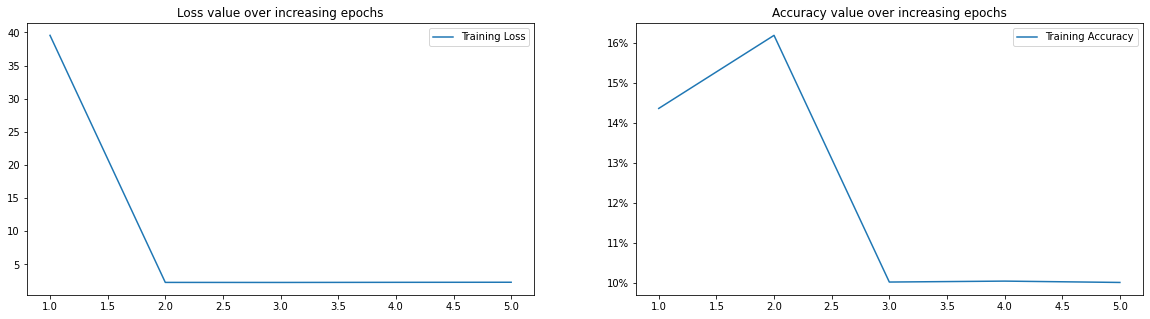

In [9]:
epochs = np.arange(5)+1
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, losses, label='Training Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()